In [89]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import re
import sys
from fa2_modified import ForceAtlas2

## Load the data

In [173]:
url = "https://raw.githubusercontent.com/JonatanRasmussen/dtu-course-browser/refs/heads/main/website/static/csv_files/course_df.csv"
df = pd.read_csv(url)

df.info()

def extract_course_numbers(text):
    return re.findall(r'\d+', text)

# Formatting the data
df.replace("No data", "N/A", inplace=True)
df.replace("NO_DATA", "N/A", inplace=True)
df['MAIN_RESPONSIBLE_COURSES'] = df['MAIN_RESPONSIBLE_COURSES'].apply(extract_course_numbers)
df['CO_RESPONSIBLE_1_COURSES'] = df['CO_RESPONSIBLE_1_COURSES'].apply(extract_course_numbers)
df['CO_RESPONSIBLE_2_COURSES'] = df['CO_RESPONSIBLE_2_COURSES'].apply(extract_course_numbers)
df['CO_RESPONSIBLE_3_COURSES'] = df['CO_RESPONSIBLE_3_COURSES'].apply(extract_course_numbers)
df['CO_RESPONSIBLE_4_COURSES'] = df['CO_RESPONSIBLE_4_COURSES'].apply(extract_course_numbers)

df.head(10)[['COURSE', 'MAIN_RESPONSIBLE_NAME', 'CO_RESPONSIBLE_1_NAME', 'CO_RESPONSIBLE_2_NAME', 'CO_RESPONSIBLE_3_NAME', 'CO_RESPONSIBLE_4_NAME']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Columns: 225 entries, COURSE to CO_RESPONSIBLE_4_COURSES
dtypes: float64(1), int64(115), object(109)
memory usage: 2.9+ MB


,COURSE,MAIN_RESPONSIBLE_NAME,CO_RESPONSIBLE_1_NAME,CO_RESPONSIBLE_2_NAME,CO_RESPONSIBLE_3_NAME,CO_RESPONSIBLE_4_NAME
0,01001,Ulrik Engelund Pedersen,Pieter Hendrik Turdus Beelen,N/A,N/A,N/A
1,01002,Ulrik Engelund Pedersen,Jakob Lemvig,N/A,N/A,N/A
2,01003,Ulrik Engelund Pedersen,Pieter Hendrik Turdus Beelen,N/A,N/A,N/A
3,01004,Ulrik Engelund Pedersen,Jakob Lemvig,N/A,N/A,N/A
4,01005,Ulrik Engelund Pedersen,N/A,N/A,N/A,N/A
5,01006,Ulrik Engelund Pedersen,N/A,N/A,N/A,N/A
6,01015,Ulrik Engelund Pedersen,N/A,N/A,N/A,N/A
7,01017,David Earl Roberson,Carsten Thomassen,N/A,N/A,N/A
8,01018,Maria Montanucci,Pieter Hendrik Turdus Beelen,N/A,N/A,N/A
9,01019,David Earl Roberson,Carsten Thomassen,N/A,N/A,N/A


## Bipartite graph of top 5 most connected responsibles

Top 5 Most Connected Courses:
Responsible: Bjarke Nielsen, Degree: 41
Responsible: Ida Stub Johansson, Degree: 31
Responsible: Bo Ea Holst-Christensen, Degree: 27
Responsible: Samuel Brüning Larsen, Degree: 17
Responsible: Martha Lynn Aulbaugh Eriksen, Degree: 16


100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1619.35it/s]

BarnesHut Approximation  took  0.03  seconds
Repulsion forces  took  0.08  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


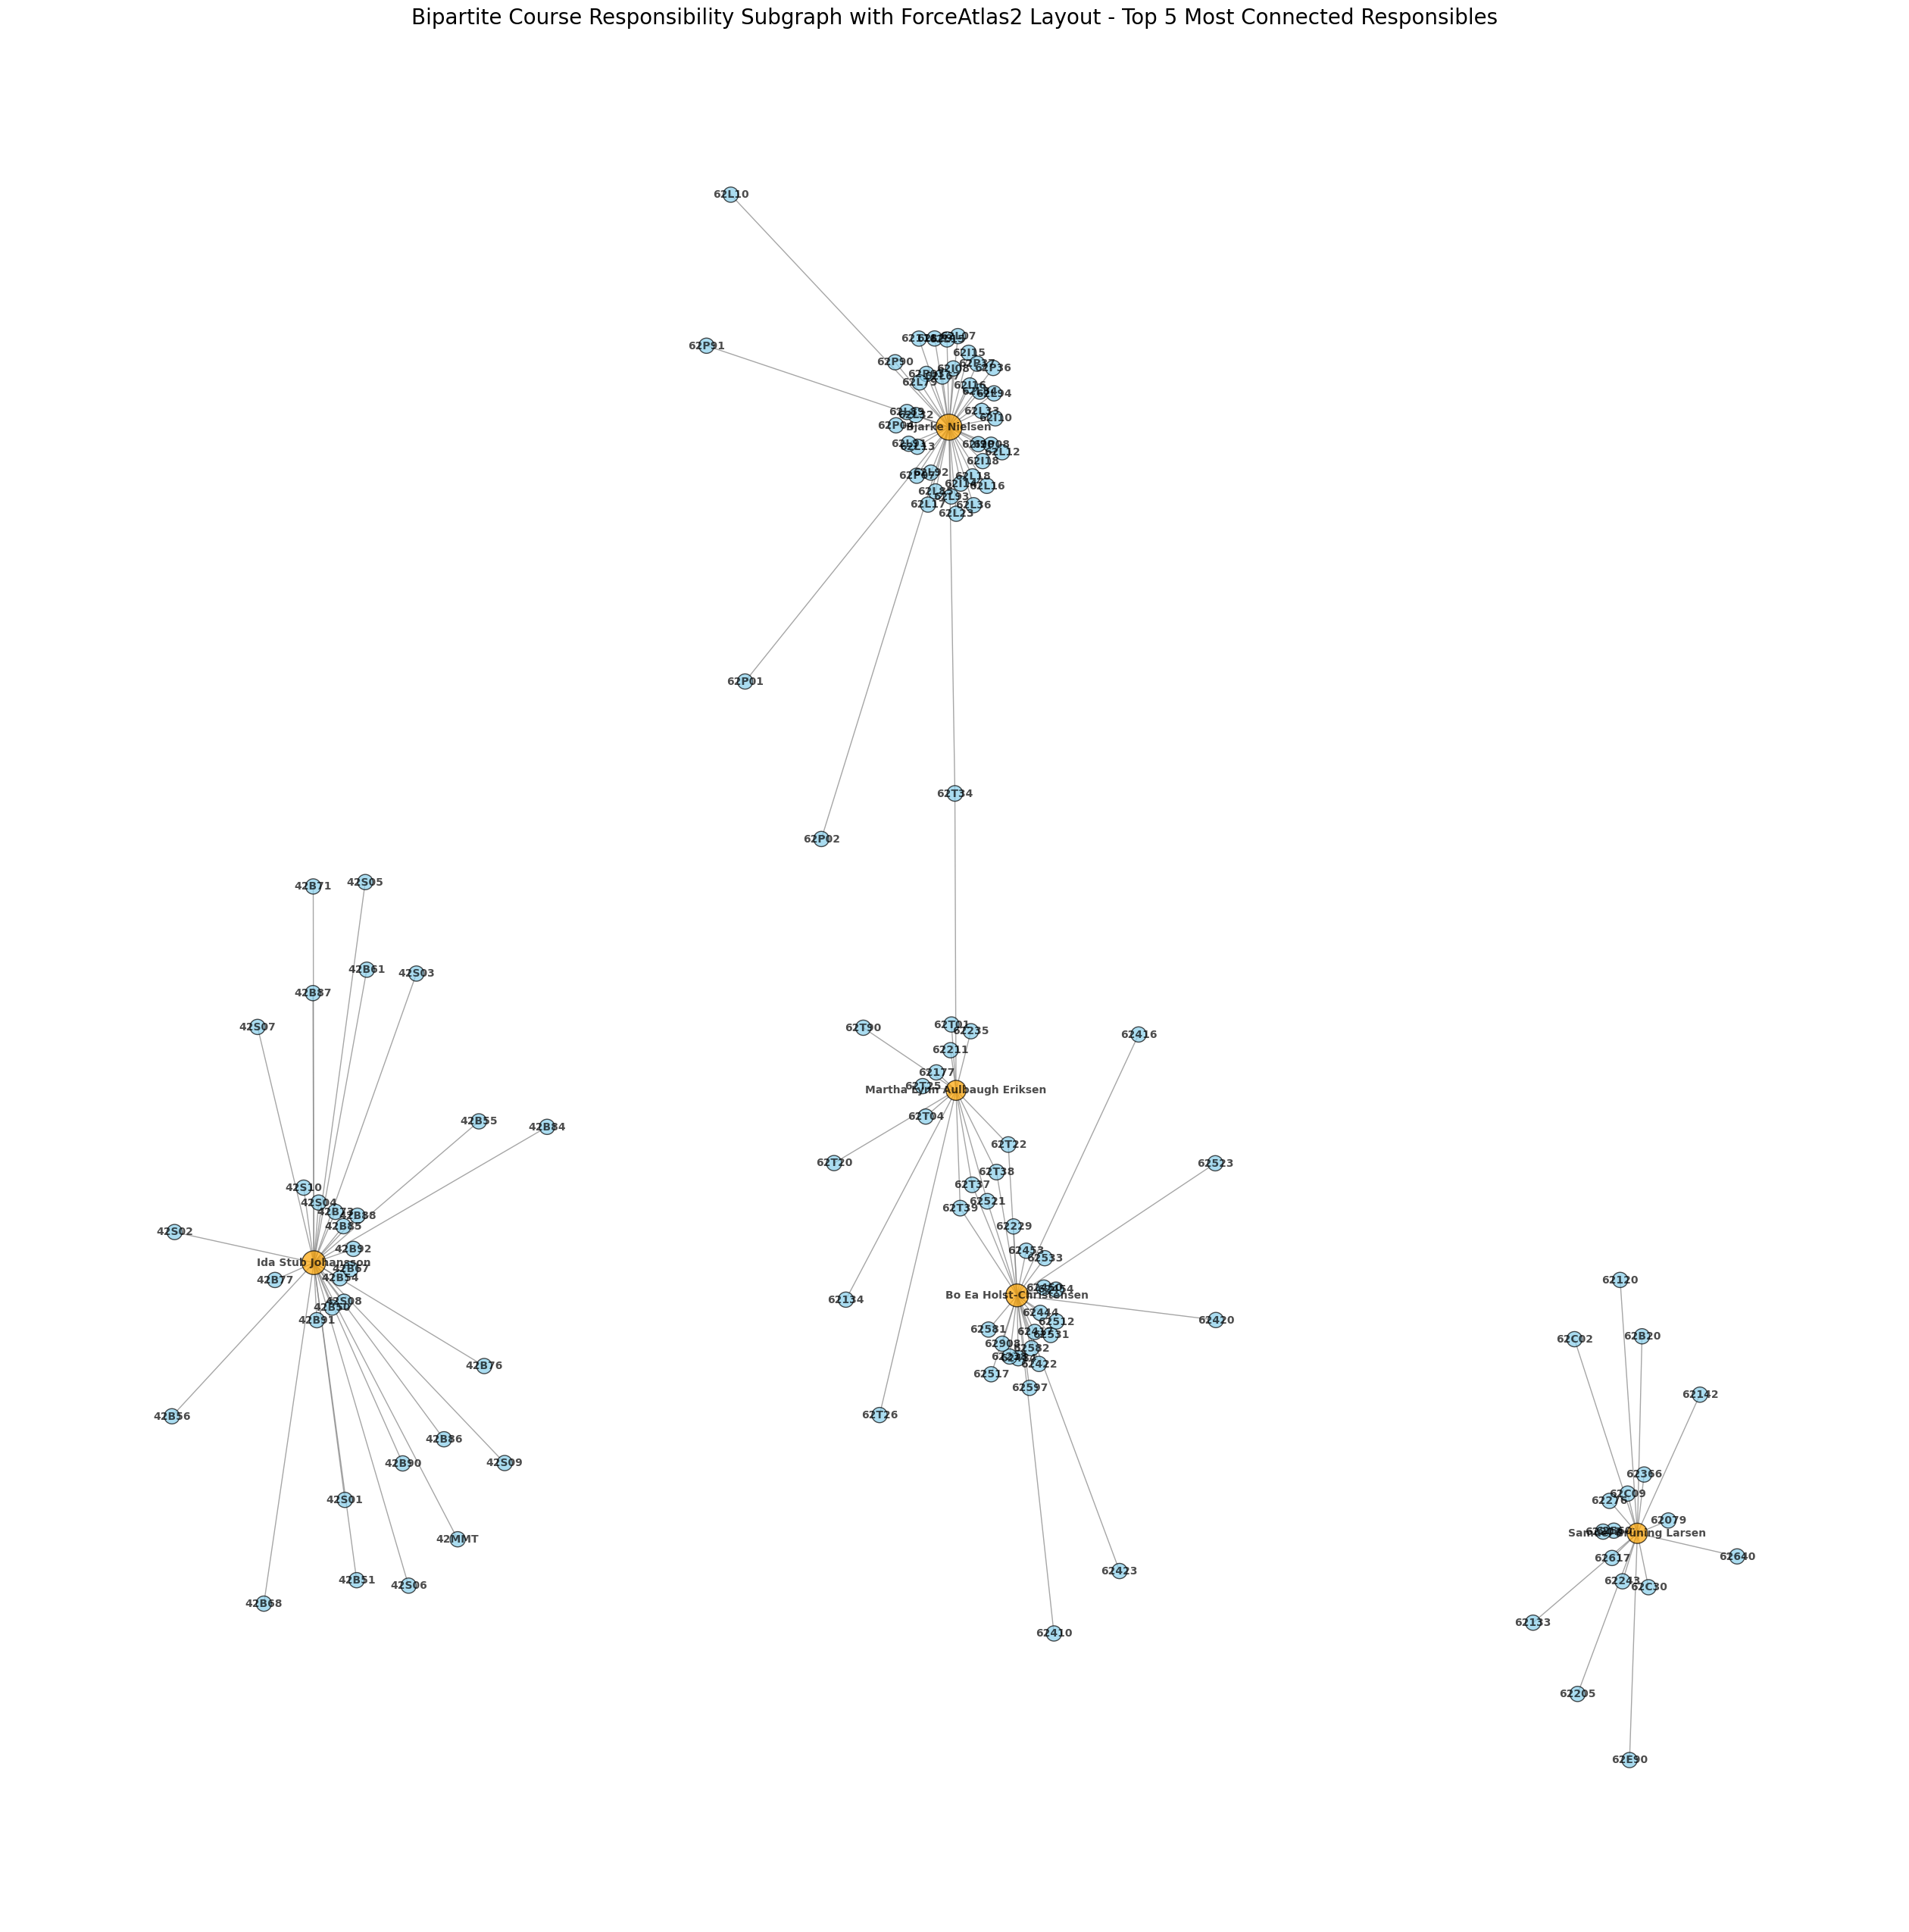

In [189]:
top = 5

G = nx.Graph()

for index, row in df.iterrows():
    course_id = row['COURSE']
    responsible_names = [
        row['MAIN_RESPONSIBLE_NAME'],
        row['CO_RESPONSIBLE_1_NAME'],
        row['CO_RESPONSIBLE_2_NAME'],
        row['CO_RESPONSIBLE_3_NAME'],
        row['CO_RESPONSIBLE_4_NAME']
    ]
    
    for responsible_name in responsible_names:
        if responsible_name and responsible_name != "N/A":
            G.add_edge(course_id, responsible_name)


degree_dict = dict(G.degree()) 
sorted_responsibles = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)
top_responsibles = [responsible for responsible, degree in sorted_responsibles[:top]]

print("Top 5 Most Connected Courses:")
for responsible in top_responsibles:
    print(f"Responsible: {responsible}, Degree: {degree_dict[responsible]}")

# Collect courses connected to the top responsible names
connected_courses = set()
for responsible in top_responsibles:
    connected_courses.update(G.neighbors(responsible))

# Combine top responsible names and their connected courses
nodes_to_include = set(top_responsibles).union(connected_courses)
subgraph = G.subgraph(nodes_to_include).copy()

node_colors = [
    'orange' if node in top_responsibles else 'skyblue' 
    for node in subgraph.nodes
]

forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,  
    linLogMode=False,                     
    adjustSizes=False,                    
    gravity=1.0,                          
    scalingRatio=2.0,                     
    strongGravityMode=False,              
    verbose=True                           
)

positions = forceatlas2.forceatlas2_networkx_layout(subgraph, iterations=200)
node_sizes = [200 + 10 * subgraph.degree(node) for node in subgraph.nodes]

plt.figure(figsize=(25, 25))
nx.draw(
    subgraph,
    pos=positions,
    with_labels=True,
    node_size=node_sizes,
    node_color=node_colors,
    font_size=10,
    font_weight='bold',
    edge_color='gray',
    width=1,
    alpha=0.7,
    edgecolors='black'
)
    
plt.title(f"Bipartite Course Responsibility Subgraph with ForceAtlas2 Layout - Top {top} Most Connected Responsibles", fontsize=20)
plt.show()

## Bipartite graph of top 5 most connected courses

Top courses by degree:
Course: 01034, Degree: 5
Course: 01035, Degree: 5
Course: 01622, Degree: 5
Course: 02323, Degree: 5
Course: 02402, Degree: 5


100%|█████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 24998.09it/s]

BarnesHut Approximation  took  0.00  seconds
Repulsion forces  took  0.00  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds


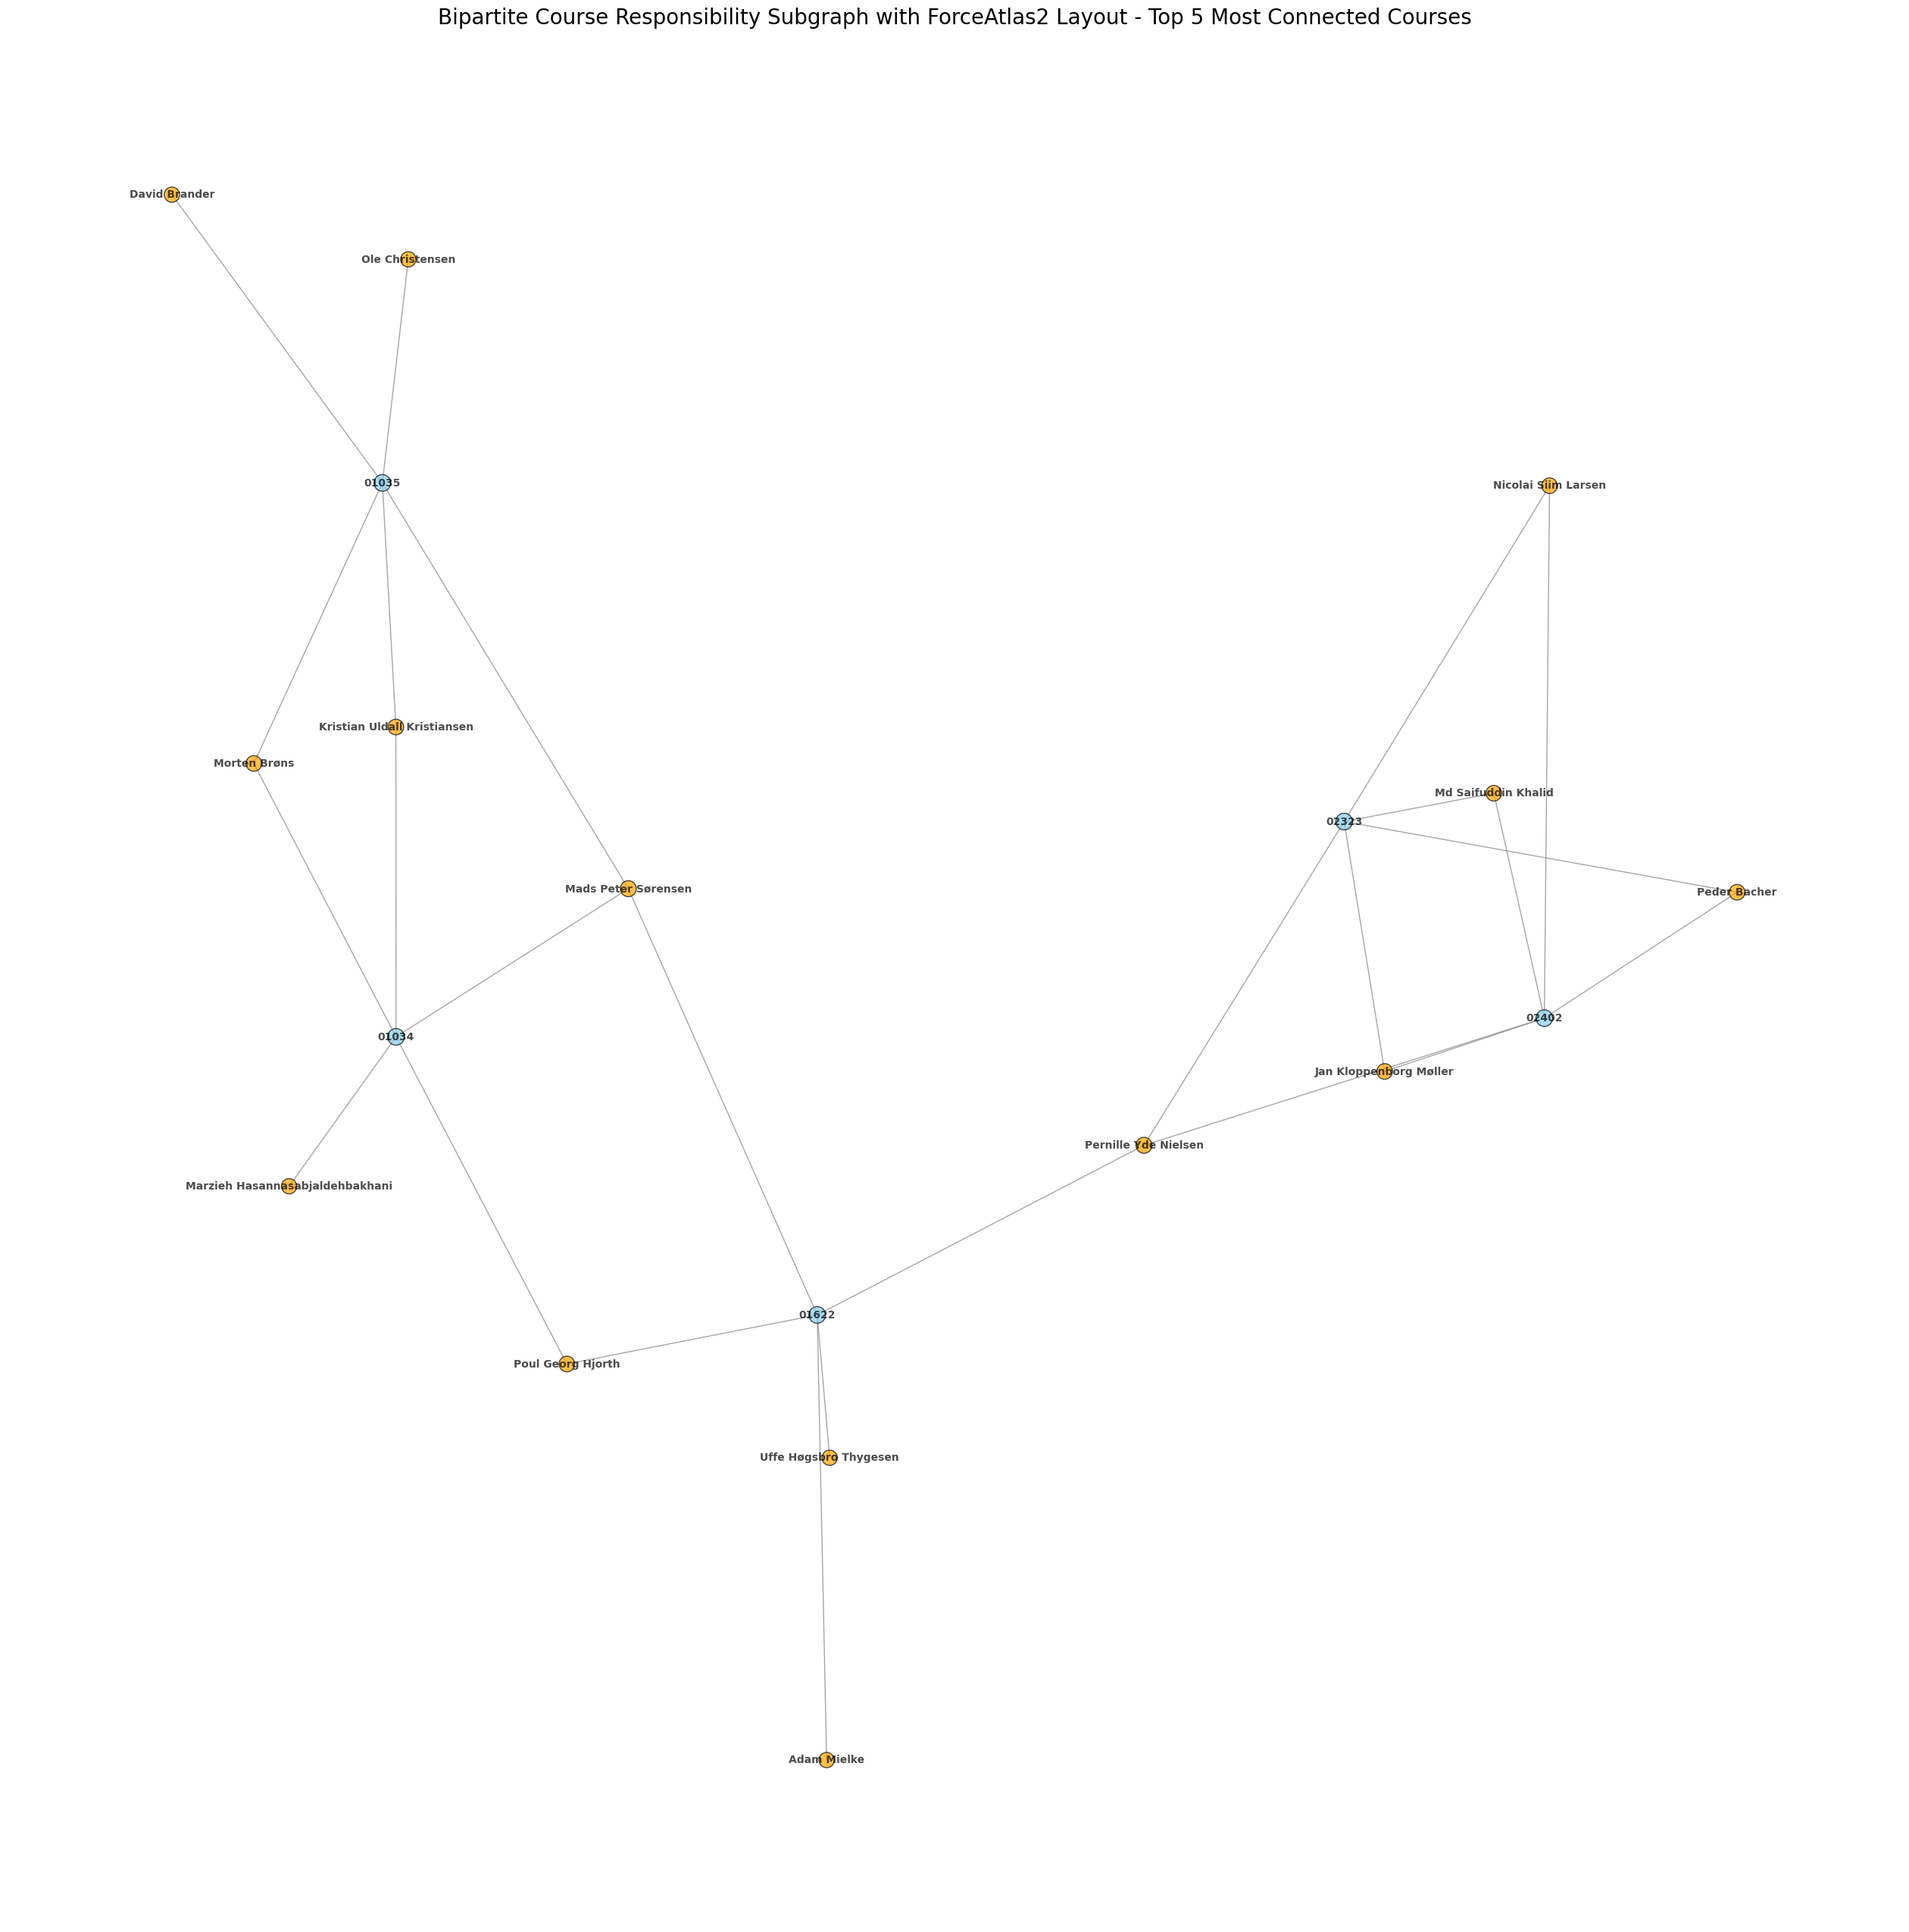

In [190]:
top = 5

degree_dict_courses = {node: degree for node, degree in G.degree() if node not in responsible_to_courses}
sorted_courses = sorted(degree_dict_courses.items(), key=lambda x: x[1], reverse=True)
top_courses = [course for course, degree in sorted_courses[:top]]


print("Top courses by degree:")
for course in top_courses:
    print(f"Course: {course}, Degree: {degree_dict_courses[course]}")


connected_responsibles = set()
for course in top_courses:
    connected_responsibles.update(G.neighbors(course))


nodes_to_include_courses = set(top_courses).union(connected_responsibles)
subgraph_courses = G.subgraph(nodes_to_include_courses).copy()

node_colors = [
    'skyblue' if node in top_courses else 'orange' 
    for node in subgraph_courses.nodes
]

forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,  
    linLogMode=False,                     
    adjustSizes=False,                    
    gravity=1.0,                          
    scalingRatio=2.0,                     
    strongGravityMode=False,              
    verbose=True                           
)

positions_courses = forceatlas2.forceatlas2_networkx_layout(subgraph_courses, iterations=200)
node_sizes_courses = [200 + 10 * subgraph_courses.degree(node) for node in subgraph_courses.nodes]

plt.figure(figsize=(25, 25))
nx.draw(
    subgraph_courses,
    pos=positions_courses,
    with_labels=True,  
    node_size=node_sizes_courses,
    node_color=node_colors,
    font_size=10,
    font_weight='bold',
    edge_color='gray',
    width=1,
    alpha=0.7,
    edgecolors='black'
)

plt.title(f"Bipartite Course Responsibility Subgraph with ForceAtlas2 Layout - Top {top} Most Connected Courses", fontsize=20)
plt.show()

## Largest component of courses connected by responsibles

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 117.37it/s]


BarnesHut Approximation  took  0.39  seconds
Repulsion forces  took  1.97  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.09  seconds
Top 5 nodes by degree:
Node: 62T34, Degree: 55
Node: 62P36, Degree: 51
Node: 62I90, Degree: 45
Node: 62118, Degree: 45
Node: 62I18, Degree: 45


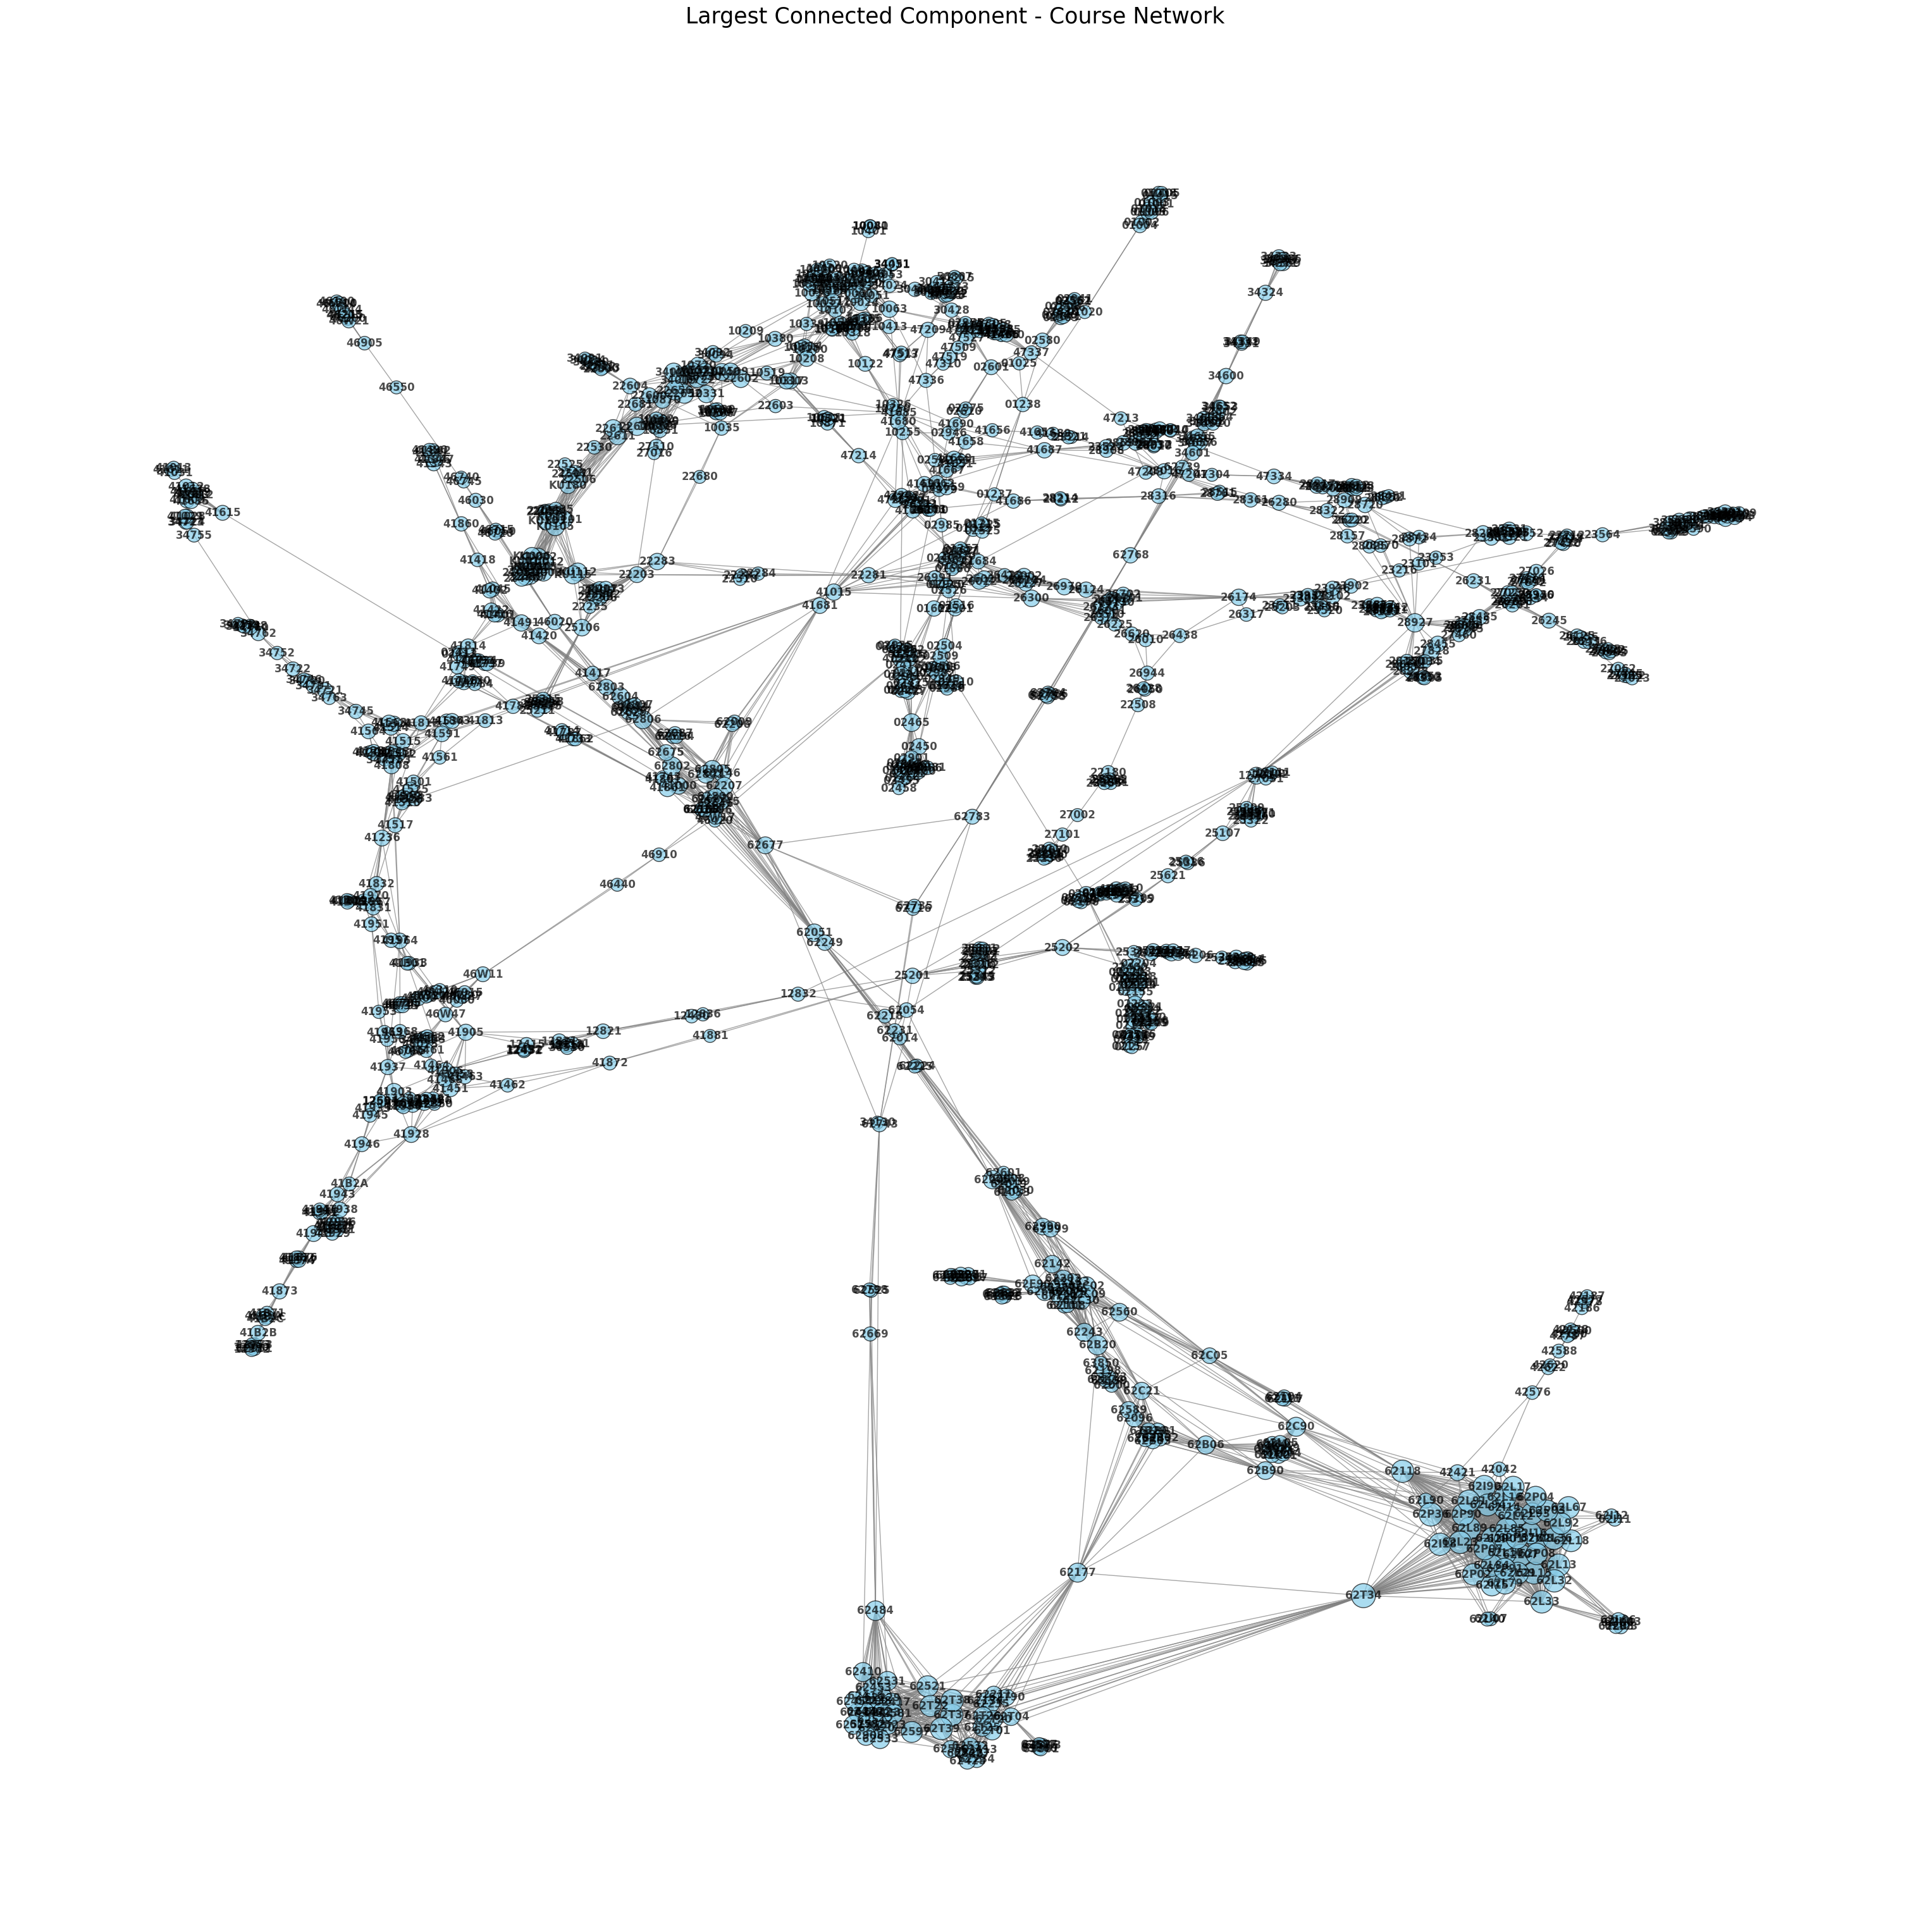

In [194]:
G_courses = nx.Graph()
responsible_to_courses = {}

for index, row in df.iterrows():
    course_id = row['COURSE']
    responsible_names = [
        row['MAIN_RESPONSIBLE_NAME'],
        row['CO_RESPONSIBLE_1_NAME'],
        row['CO_RESPONSIBLE_2_NAME'],
        row['CO_RESPONSIBLE_3_NAME'],
        row['CO_RESPONSIBLE_4_NAME']
    ]
    
    # For each responsible name, associate it with the corresponding course
    for responsible_name in responsible_names:
        if responsible_name and responsible_name != "N/A":
            if responsible_name not in responsible_to_courses:
                responsible_to_courses[responsible_name] = []
            responsible_to_courses[responsible_name].append(course_id)

# Add edges between courses that share at least one responsible
for responsible, courses in responsible_to_courses.items():
    for i in range(len(courses)):
        for j in range(i + 1, len(courses)):
            G_courses.add_edge(courses[i], courses[j])


largest_component = max(nx.connected_components(G_courses), key=len)
largest_subgraph = G_courses.subgraph(largest_component).copy()

forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,  
    linLogMode=False,                     
    adjustSizes=False,                    
    gravity=1.5,                          
    scalingRatio=1.5,                     
    strongGravityMode=False,              
    verbose=True                           
)

# Apply ForceAtlas2 layout for node positioning
positions_courses = forceatlas2.forceatlas2_networkx_layout(largest_subgraph, iterations=300)

node_sizes = [200 + 10 * largest_subgraph.degree(node) for node in largest_subgraph.nodes]

plt.figure(figsize=(30, 30))

nx.draw(
    largest_subgraph,
    pos=positions_courses,
    with_labels=True,
    node_size=node_sizes,
    font_size=12,  
    font_weight='bold',
    edge_color='gray',
    width=1,
    alpha=0.7,  
    edgecolors='black',
    node_color='skyblue',  
    font_color='black'    
)


top_5_nodes = sorted(largest_subgraph.degree(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes by degree:")
for node, degree in top_5_nodes:
    print(f"Node: {node}, Degree: {degree}")

plt.title(f"Largest Connected Component - Course Network", fontsize=25)
plt.show()